# MCMC and Geweke test on a simple birth-death model

In [12]:
from gcdyn import models, mutators, poisson, utils
from scipy.stats import gamma, lognorm
from functools import partial
import numpy as np
import seaborn as sns
from mcmc import mh_step, mh_tour
from jax import jit, disable_jit
from jax.config import config
import matplotlib.pyplot as plt
from tqdm import notebook as tqdm
import pickle

config.update("jax_enable_x64", True)

## Posterior inference on constant birth/death rate parameters

In [2]:
true_parameters = {
    "birth_response": poisson.ConstantResponse(2),
    "death_response": poisson.ConstantResponse(1),
    "mutation_response": poisson.ConstantResponse(0),
    "mutator": mutators.DiscreteMutator(
        state_space=(1, 2, 3),
        transition_matrix=utils.random_transition_matrix(length=3),
    ),
    "extant_sampling_probability": 1,
}

PRESENT_TIME = 2

trees = utils.sample_trees(n=5, t=PRESENT_TIME, seed=5, **true_parameters)

for tree in trees:
    tree._pruned = True
    # to let σ=1

Notice: obtained error 'number of survivors 0 is less than min_survivors=1' 7 times.
Success: average of 37.2 nodes per tree, over 5 trees.


In [3]:
BIRTH_PROPOSAL_SD = 0.2
DEATH_PROPOSAL_SD = 0.2

prior_log_densities = {
    "birth_response": lambda response: gamma(1).logpdf(response.value),
    "death_response": lambda response: gamma(1).logpdf(response.value),
}

proposal_generators = {
    "birth_response": lambda current: poisson.ConstantResponse(
        lognorm(scale=current.value, s=BIRTH_PROPOSAL_SD).rvs(size=1).item()
    ),
    "death_response": lambda current: poisson.ConstantResponse(
        lognorm(scale=current.value, s=DEATH_PROPOSAL_SD).rvs(size=1).item()
    ),
}

proposal_log_densities = {
    "birth_response": lambda p, c: lognorm(scale=c.value, s=BIRTH_PROPOSAL_SD).logpdf(
        p.value
    ),
    "death_response": lambda p, c: lognorm(scale=c.value, s=DEATH_PROPOSAL_SD).logpdf(
        p.value
    ),
}


log_likelihood = jit(
    partial(
        models.stadler_full_log_likelihood,
        trees=trees,
        mutation_response=true_parameters["mutation_response"],
        mutator=true_parameters["mutator"],
        extant_sampling_probability=true_parameters["extant_sampling_probability"],
        extinct_sampling_probability=1,
        present_time=PRESENT_TIME,
    )
)

In [4]:
samples = mh_tour(
    num_samples=5000,
    initial_value={
        "birth_response": poisson.ConstantResponse(1),
        "death_response": poisson.ConstantResponse(2),
    },
    log_priors=prior_log_densities,
    log_likelihood=log_likelihood,
    proposal_generators=proposal_generators,
    proposal_log_densities=proposal_log_densities,
)

samples = {
    "birth_response": np.hstack([s.value for s in samples["birth_response"]]),
    "death_response": np.hstack([s.value for s in samples["death_response"]]),
}

  0%|          | 0/5000 [00:00<?, ?it/s]

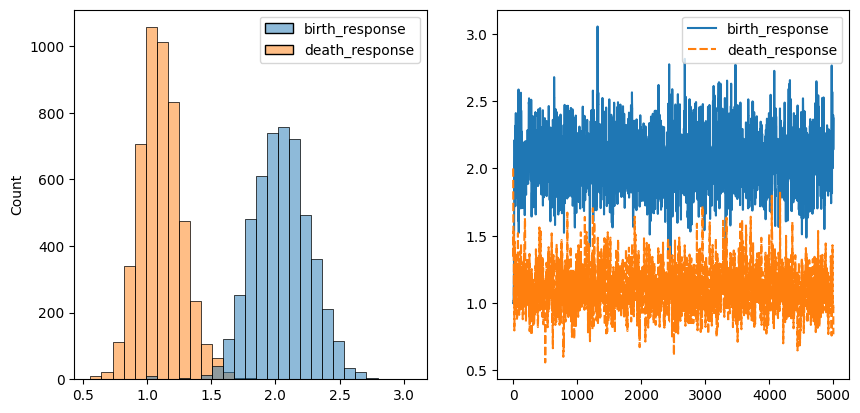

In [5]:
fig, axes = plt.subplots(1, 2)
sns.histplot(samples, ax=axes[0])
sns.lineplot(samples, ax=axes[1])
fig.set_figwidth(10)
plt.show()

In [6]:
acceptance_ratio_birth = np.mean(
    samples["birth_response"][:-1] != samples["birth_response"][1:]
)
acceptance_ratio_death = np.mean(
    samples["death_response"][:-1] != samples["death_response"][1:]
)

print(f"Accepted {acceptance_ratio_birth*100}% of birth response proposals")
print(f"Accepted {acceptance_ratio_death*100}% of death response proposals")

Accepted 52.86% of birth response proposals
Accepted 61.36000000000001% of death response proposals


## Geweke test

In [7]:
NUM_SAMPLES = 2000

### Monte Carlo sampling

In [8]:
def sample_prior():
    return {
        "birth_response": poisson.ConstantResponse(gamma(1).rvs(size=1).item()),
        "death_response": poisson.ConstantResponse(gamma(1).rvs(size=1).item()),
    }

In [9]:
mc_samples = [sample_prior() for _ in range(NUM_SAMPLES)]

mc_samples = {
    "birth_response": np.hstack([s["birth_response"].value for s in mc_samples]),
    "death_response": np.hstack([s["death_response"].value for s in mc_samples]),
}

### Gibbs sampling

In [10]:
# Function of just birth_rate and death_rate
sample_tree = partial(
    utils.sample_trees,
    n=1,
    t=PRESENT_TIME,
    mutation_response=true_parameters["mutation_response"],
    mutator=true_parameters["mutator"],
    extant_sampling_probability=true_parameters["extant_sampling_probability"],
    min_survivors=0,
)

log_likelihood = partial(
    models.stadler_full_log_likelihood,
    mutation_response=true_parameters["mutation_response"],
    mutator=true_parameters["mutator"],
    extant_sampling_probability=true_parameters["extant_sampling_probability"],
    extinct_sampling_probability=1,
    present_time=PRESENT_TIME,
)

In [13]:
# Initialize with the truth
mcmc_samples = [
    {param: true_parameters[param] for param in ("birth_response", "death_response")}
]

with disable_jit():
    for _ in tqdm.trange(NUM_SAMPLES):
        trees = sample_tree(**mcmc_samples[-1], print_info=False)

        for tree in trees:
            tree._pruned = True

        params = mh_step(
            from_values=mcmc_samples[-1],
            log_priors=prior_log_densities,
            log_likelihood=partial(log_likelihood, trees=trees),
            proposal_generators=proposal_generators,
            proposal_log_densities=proposal_log_densities,
        )

        mcmc_samples.append(params)

mcmc_samples = {
    "birth_response": np.hstack([s["birth_response"].value for s in mcmc_samples]),
    "death_response": np.hstack([s["death_response"].value for s in mcmc_samples]),
}

  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

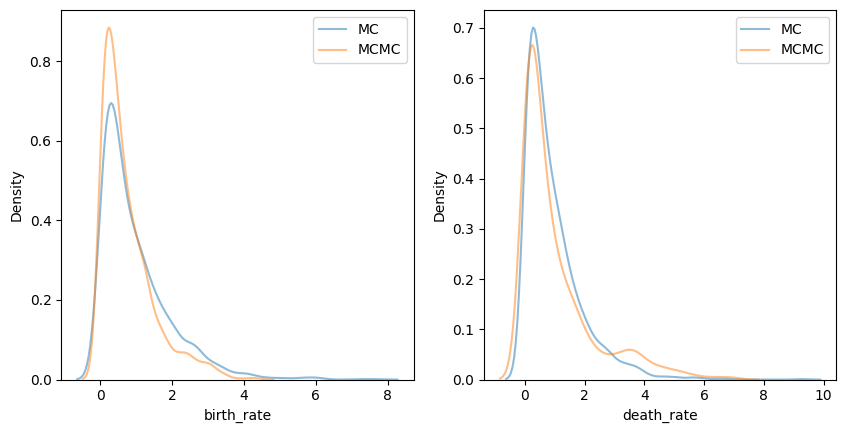

In [21]:
fig, axes = plt.subplots(1, len(mc_samples))

for ax, param in zip(axes, mc_samples):
    sns.kdeplot(mc_samples[param], alpha=0.5, label="MC", ax=ax)
    sns.kdeplot(mcmc_samples[param], alpha=0.5, label="MCMC", ax=ax)
    ax.legend()
    ax.set_xlabel(param)

fig.set_figwidth(10)
plt.show()

In [ ]:
with open("geweke_samples.pkl", "wb") as f:
    pickle.dump({"mc_samples": mc_samples, "mcmc_samples": mcmc_samples}, f)